- 해당 코드 돌리기 전에 비디오 다이콤 > avi형태로 변환 > png 파일로 변환 완료후 실행

# image preprocessing

In [ ]:
import numpy as np
import os
from glob import glob 
import pandas as pd

import matplotlib.pyplot as plt
import cv2

# CSV 

In [57]:
import pandas as pd
import re

In [58]:
CAUH_df = pd.read_csv('/home/work/LUS/Dataset/CAUH/[External]CAUH.csv', index_col=False)

print(len(CAUH_df))

319


In [59]:
CAUH_df['File_name'] = [i.split('.')[0] for i in CAUH_df['filename']]
CAUH_df['File_id'] = [i.split('/')[1].split('.')[0] for i in CAUH_df['filename']]
CAUH_df['Patient_id'] = [i.split('/')[0] for i in CAUH_df['filename']]
CAUH_df.head()

,filename,A,B,Effusion,Consolidation,File_name,File_id,Patient_id
0,1/1_1.png,0,1,1,1,1/1_1,1_1,1
1,1/2_1.png,1,0,0,0,1/2_1,2_1,1
2,1/3_1.png,0,1,0,0,1/3_1,3_1,1
3,1/4_1.png,0,0,0,0,1/4_1,4_1,1
4,1/5_1.png,0,0,0,0,1/5_1,5_1,1


# load png file paths

In [60]:
from tqdm import tqdm

In [61]:
from glob import glob

all_png_paths = glob('/home/work/LUS/Dataset/CAUH/CAUH_preprocessed_img_LJH/*/*.png')

In [62]:
print(len(all_png_paths))

282


In [63]:
all_png_paths[0]

'/home/work/LUS/Dataset/CAUH/CAUH_preprocessed_img_LJH/47/3_1.png'

In [25]:
data2 = []

# 이미지 case는 제외하기 위해
pattern = re.compile(r'(\d+_\d+)_\d+')

for i in tqdm(range(len(all_png_paths))):
    Patient_id = all_png_paths[i].split('/')[-2]
    File_id = all_png_paths[i].split('/')[-1].split('.')[0]
    File_name = f'{Patient_id}/{File_id}'
        
    data2.append({
        'Patient_id': Patient_id,
        'File_id' : File_id,
        'File_name': File_name
    })

png_df = pd.DataFrame(data2, columns=['Patient_id', 'File_id', 'File_name'])

100% 282/282 [00:00<00:00, 321586.11it/s]


In [26]:
png_df.head()

,Patient_id,File_id,File_name
0,47,3_1,47/3_1
1,47,1_1,47/1_1
2,47,5_1,47/5_1
3,47,4_1,47/4_1
4,47,2_1,47/2_1


# png csv, labeling csv merge
- linear probe image 제거 : 37 frames

In [31]:
len(CAUH_merged_df)

282

In [36]:
# 데이터프레임 merge
CAUH_merged_df = pd.merge(CAUH_df, png_df, on='File_name', how='inner', suffixes=('', '_drop'))

columns_to_drop = [col for col in CAUH_merged_df.columns if col.endswith('_drop')]
CAUH_merged_df = CAUH_merged_df.drop(columns=columns_to_drop)

print(f"CAUH image 개수: {len(CAUH_merged_df)}")
CAUH_merged_df.head()

CAUH image 개수: 282


,filename,A,B,Effusion,Consolidation,File_name,Patient_id,File_id
0,1/1_1.png,0,1,1,1,1/1_1,1,1_1
1,1/2_1.png,1,0,0,0,1/2_1,1,2_1
2,1/3_1.png,0,1,0,0,1/3_1,1,3_1
3,1/4_1.png,0,0,0,0,1/4_1,1,4_1
4,1/5_1.png,0,0,0,0,1/5_1,1,5_1


In [37]:
def create_path(row):
    root_path = "/home/work/LUS/Dataset/CAUH/CAUH_preprocessed_img_LJH"
    patient_id = int(row['Patient_id'])
    File_id = row['File_id']
    return f"{root_path}/{patient_id}/{File_id}.png"

In [38]:
CAUH_merged_df['img_path'] = CAUH_merged_df.apply(create_path, axis=1)

print(CAUH_merged_df.iloc[0]['img_path'])

/home/work/LUS/Dataset/CAUH/CAUH_preprocessed_img_LJH/1/1_1.png


In [41]:
score_cols = {'A':0, 
              'B':1, 
              'Consolidation':3, 
              'Effusion':3}

def assign_LUS_score(row):
    # 각 레이블에 대해 점수 계산
    scores = []
    for label, score in score_cols.items():
        if row[label] > 0:  # 레이블이 존재하는 경우
            scores.append(score)
    # 가장 높은 점수 반환, 레이블이 없는 경우 기본값으로 가장 낮은 점수 할당
    return max(scores) if scores else 4

In [43]:
CAUH_merged_df['Lung ultrasound score_lbl'] = CAUH_merged_df.apply(assign_LUS_score, axis=1)

In [40]:
import matplotlib.pyplot as plt
import seaborn as sns

In [44]:
value_counts = CAUH_merged_df['Lung ultrasound score_lbl'].value_counts().sort_index()

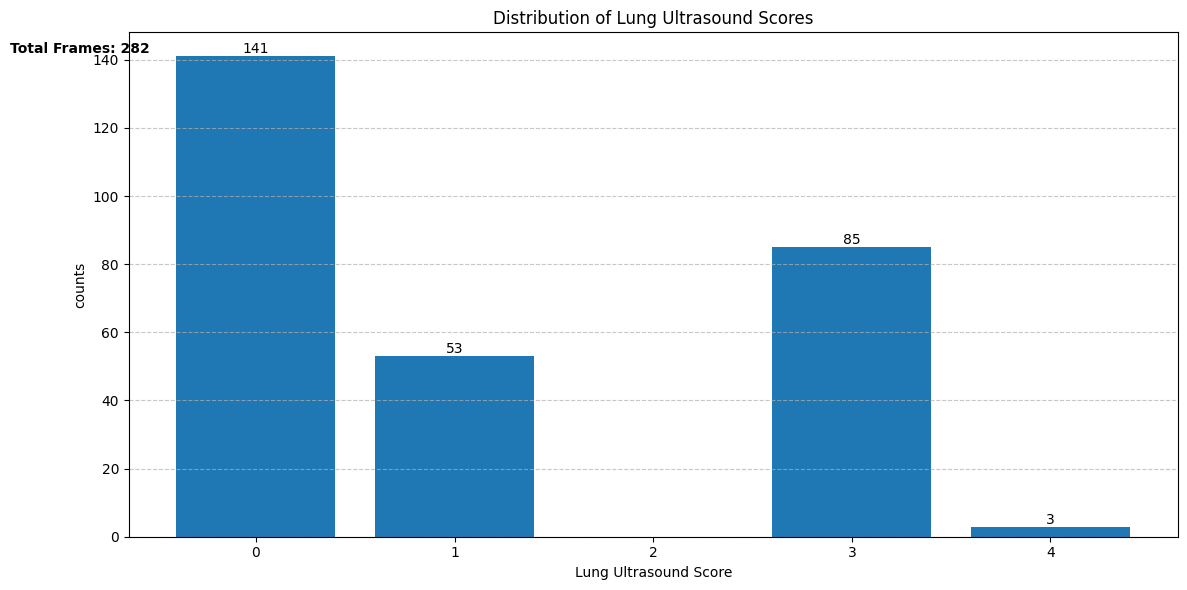

In [45]:
plt.figure(figsize=(12, 6))
bars = plt.bar(value_counts.index, value_counts.values)
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height,
             f'{height}',
             ha='center', va='bottom')

plt.title('Distribution of Lung Ultrasound Scores')
plt.xlabel('Lung Ultrasound Score')
plt.ylabel('counts')
plt.xticks(rotation=0) 
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Total frame 수 계산
total_frames = value_counts.sum()

# Total frame 수를 그래프 왼쪽 위에 표시
plt.text(0.02, 0.98, f'Total Frames: {total_frames}', 
         transform=plt.gca().transAxes,
         verticalalignment='top', horizontalalignment='right',
         fontsize=10, fontweight='bold')

plt.tight_layout()
plt.show()

- 5 artifacts
    - A-line / B-line / confluent B-line / Consolidation / Effusion

In [46]:
# score 4 제외
class_5_new_df = CAUH_merged_df[CAUH_merged_df['Lung ultrasound score_lbl'] != 4]

print(len(CAUH_merged_df))
print(len(class_5_new_df))
print(len(CAUH_merged_df[CAUH_merged_df['Lung ultrasound score_lbl'] == 4]))

282
279
3


In [48]:
import os

if not os.path.exists(f'/home/work/LUS/Dataset/csv_files/CAUH/4_artifacts'):
    os.makedirs(f'/home/work/LUS/Dataset/csv_files/CAUH/4_artifacts')
class_5_new_df.to_csv(f"/home/work/LUS/Dataset/csv_files/CAUH/4_artifacts/CAUH_test.csv", index=False)

In [49]:
class_5_new_df

,filename,A,B,Effusion,Consolidation,File_name,Patient_id,File_id,img_path,Lung ultrasound score_lbl
0,1/1_1.png,0,1,1,1,1/1_1,1,1_1,/home/work/LUS/Dataset/CAUH/CAUH_preprocessed_...,3
1,1/2_1.png,1,0,0,0,1/2_1,1,2_1,/home/work/LUS/Dataset/CAUH/CAUH_preprocessed_...,0
2,1/3_1.png,0,1,0,0,1/3_1,1,3_1,/home/work/LUS/Dataset/CAUH/CAUH_preprocessed_...,1
5,1/6_1.png,1,0,0,0,1/6_1,1,6_1,/home/work/LUS/Dataset/CAUH/CAUH_preprocessed_...,0
6,10/1_1.png,0,0,1,1,10/1_1,10,1_1,/home/work/LUS/Dataset/CAUH/CAUH_preprocessed_...,3
...,...,...,...,...,...,...,...,...,...,...
277,6/6_1.png,1,0,0,0,6/6_1,6,6_1,/home/work/LUS/Dataset/CAUH/CAUH_preprocessed_...,0
278,6/7_1.png,0,0,0,1,6/7_1,6,7_1,/home/work/LUS/Dataset/CAUH/CAUH_preprocessed_...,3
279,8/1_1.png,0,0,1,1,8/1_1,8,1_1,/home/work/LUS/Dataset/CAUH/CAUH_preprocessed_...,3
280,9/1_1.png,0,0,1,0,9/1_1,9,1_1,/home/work/LUS/Dataset/CAUH/CAUH_preprocessed_...,3


In [50]:
class_5_new_df['img_path'].iloc[0]

'/home/work/LUS/Dataset/CAUH/CAUH_preprocessed_img_LJH/1/1_1.png'